In [1]:
import base64

import matplotlib.pyplot as plt
import numpy as np
import requests

from aaron_rw_tfrecord import read_tfrecord
from aaron_simple_example import *

plt.show()

tf.enable_eager_execution()


In [2]:
infile = '/tmp/data/mnist/tmp0dGBYT/train_shuffled-00000-of-00001.gz'
img = read_tfrecord(infile)
img.shape

Instructions for updating:
Colocations handled automatically by placer.


(28, 28, 1)

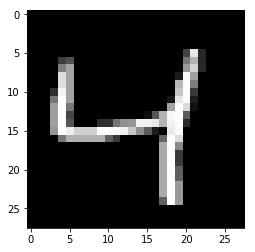

In [3]:
def display_image(img):
    """
    Coverts a 1-channel np.ndarray to 3-channel and displays it
    using matplotlib
    """
    assert isinstance(img, np.ndarray), type(img)

    stacked_img = np.stack((np.squeeze(img), ) * 3, axis=-1)
    assert stacked_img.shape == (28, 28, 3), stacked_img.shape

    plt.imshow(stacked_img, cmap=plt.get_cmap('gray'))

display_image(img)

In [4]:
# Open and read image as bitstring
image_infile = '/Users/aaron/Desktop/mnist-test-4.png'
with open(image_infile, 'rb') as f:
    input_image = f.read()

print("Raw bitstring: " + str(input_image[:10]) + " ... " + str(input_image[-10:]))

Raw bitstring: �PNG

   ...   IEND�B`�


In [5]:
# Encode image in b64
encoded_input_string = base64.b64encode(input_image)
input_string = encoded_input_string.decode("utf-8")
print("Base64 encoded string: " + input_string[:10] + " ... " + input_string[-10:])

Base64 encoded string: iVBORw0KGg ... lFTkSuQmCC


In [6]:
try:
    url = 'http://127.0.0.1:8500/v1/models/mnist:predict'
    data ={
          "inputs": input_string
        }
    r = requests.post(url, json=data)
    r, r.content
except requests.exceptions.ConnectionError:
    print('ConnectionError')

ConnectionError


In [7]:
# inspect img

In [8]:
img.shape

(28, 28, 1)

In [9]:
type(img)

numpy.ndarray

In [10]:
img_784 = np.reshape(img, (1, 784))
img_784.shape

(1, 784)

In [11]:
# png to ndarray

In [12]:
import imageio

im = imageio.imread(image_infile)
print(im.shape)

(252, 255, 4)


In [13]:
import matplotlib

stacked_img = np.stack((np.squeeze(img), ) * 3, axis=-1)

image_outfile = 'mnist-4-outfile.png'
matplotlib.image.imsave(image_outfile, stacked_img)

In [14]:
!pwd

/Users/aaron/Documents/github/transform/examples


In [15]:
!ls *.png

mnist-4-outfile.png


In [16]:
# png to ndarray

In [17]:
im = imageio.imread(image_outfile)
print(im.shape)

(28, 28, 4)


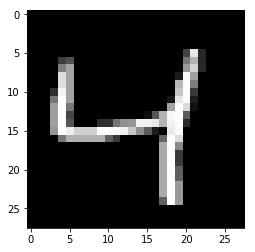

In [18]:
plt.imshow(im, cmap=plt.get_cmap('gray'))

In [19]:
# remove 4th dimension which would be alpha

In [20]:
# converts shape (28, 28, 4) to (28, 28, 3)
im_w_no_alpha_dimen = im[:,:,:3]
im_w_no_alpha_dimen.shape

(28, 28, 3)

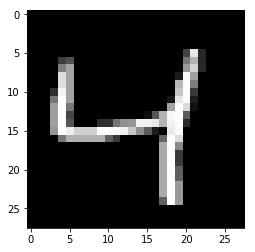

In [21]:
plt.imshow(im_w_no_alpha_dimen, cmap=plt.get_cmap('gray'))

In [22]:
# convert back to 1 channel

In [23]:
im_bw = im_w_no_alpha_dimen[:,:,0]
im_bw.shape

(28, 28)

In [24]:
restacked_im = np.stack((np.squeeze(im_bw), ) * 3, axis=-1)
restacked_im.shape

(28, 28, 3)

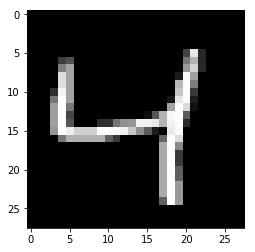

In [25]:
plt.imshow(restacked_im, cmap=plt.get_cmap('gray'))

In [26]:
im_bw_flat = np.reshape(im_bw, (1, -1))
im_bw_flat.shape

(1, 784)

In [27]:
im_bw_flat.astype('float').dtype

dtype('float64')

In [29]:
# call tensorflow-serving

In [30]:
import sys
import threading

import grpc
import tensorflow as tf
import imageio
import numpy

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

In [31]:
with open('mnist-4-outfile.png', 'rb') as f:
    image_byte_str = f.read()

In [37]:
class _ResultCounter(object):
  """Counter for the prediction results."""

  def __init__(self, num_tests, concurrency):
    self._num_tests = num_tests
    self._concurrency = concurrency
    self._error = 0
    self._done = 0
    self._active = 0
    self._condition = threading.Condition()

  def inc_error(self):
    with self._condition:
      self._error += 1

  def inc_done(self):
    with self._condition:
      self._done += 1
      self._condition.notify()

  def dec_active(self):
    with self._condition:
      self._active -= 1
      self._condition.notify()

  def get_error_rate(self):
    with self._condition:
      while self._done != self._num_tests:
        self._condition.wait()
      return self._error / float(self._num_tests)

  def throttle(self):
    with self._condition:
      while self._active == self._concurrency:
        self._condition.wait()
      self._active += 1


def _create_rpc_callback(label, result_counter):
  """Creates RPC callback function.

  Args:
    label: The correct label for the predicted example.
    result_counter: Counter for the prediction result.
  Returns:
    The callback function.
  """
  def _callback(result_future):
    """Callback function.

    Calculates the statistics for the prediction result.

    Args:
      result_future: Result future of the RPC.
    """
    exception = result_future.exception()
    if exception:
      result_counter.inc_error()
      print(exception)
    else:
      sys.stdout.write('.')
      sys.stdout.flush()
      response = numpy.array(
          result_future.result().outputs['scores'].float_val)
      prediction = numpy.argmax(response)
      print('label:', label, '; prediction:', prediction)
      if label != prediction:
        result_counter.inc_error()
    result_counter.inc_done()
    result_counter.dec_active()
  return _callback

In [38]:
hostport = '127.0.0.1:8500'
work_dir = '/tmp'
concurrency = 1
num_tests = 1

In [39]:
channel = grpc.insecure_channel(hostport)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
result_counter = _ResultCounter(num_tests, concurrency)

request = predict_pb2.PredictRequest()
request.model_spec.name = 'mnist'
request.model_spec.signature_name = 'predict_images'
### Aaron - start
# run for local image file instead
infile = '/Users/aaron/Documents/github/transform/examples/mnist-4-outfile.png'
# shape (28, 28, 4)
im = imageio.imread(infile)
# convert to black-n-white
im_bw = im[:,:,0]
# flatten to (1, 784); same shape as above 'image'
image = np.reshape(im_bw, (1, -1)).astype('float32')
label = np.array([4])
### Aaron - end
request.inputs['images'].CopyFrom(
  tf.contrib.util.make_tensor_proto(image[0], shape=[1, image[0].size]))
result_counter.throttle()
result_future = stub.Predict.future(request, 5.0)  # 5 seconds

result_future.add_done_callback(
  _create_rpc_callback(label[0], result_counter))

result_counter.get_error_rate()

.('label:', 4, '; prediction:', 4)


0.0

In [36]:
result_future

{'_call': <grpc._cython.cygrpc.IntegratedCall at 0x128a7aa90>,
 '_deadline': 1557604981.761831,
 '_response_deserializer': <function FromString>,
 '_state': <grpc._channel._RPCState at 0x128a44c90>}